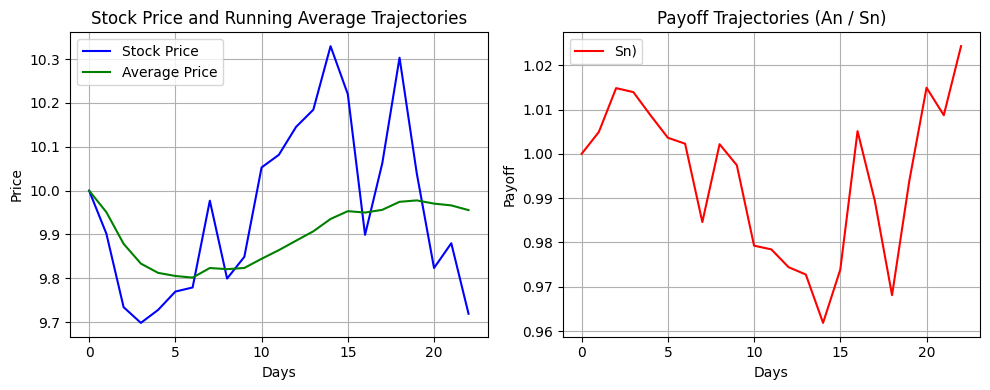

Expression théorique : 1.001748112211177
Naive MC expected payoff: 1.0017
Antithetic MC expected payoff: 1.0018


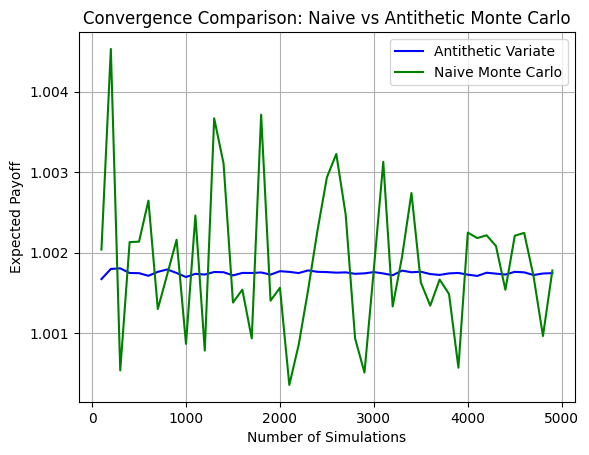

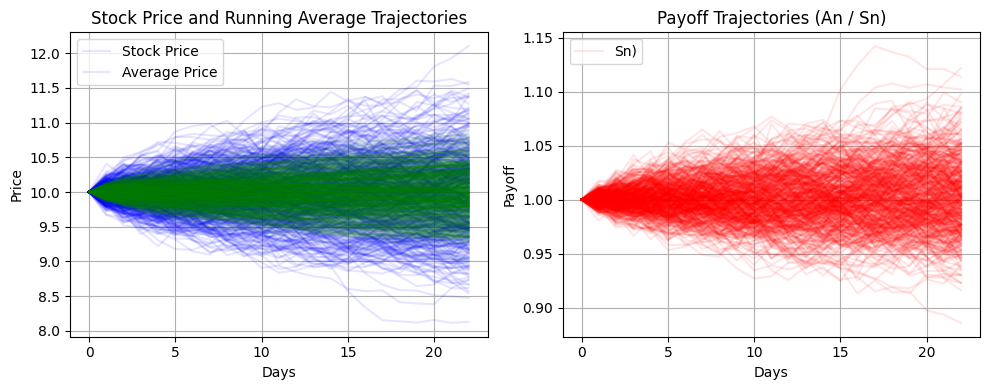

In [1]:
import numpy as np
import matplotlib.pyplot as plt

class Simulator:
    def __init__(self, s_0, sigma, n_days, num_sim, delta_t, r, o_type):
        self.s_0 = s_0
        self.sigma = sigma
        self.n_days = n_days
        self.num_sim = num_sim
        self.delta_t = delta_t
        self.r = r
        self.o_type = o_type
        self.compute_monte_carlo("-")  # Simulation initiale avec antithétique

    def compute_geometric_bm(self, var_red=None):
        e_t = np.random.normal(0, 1, (self.num_sim, self.n_days))
        if var_red:
            e_t = np.concatenate((e_t, -e_t))  # Variables antithétiques
        return np.exp((self.r - 0.5 * self.sigma**2) * self.delta_t + self.sigma * np.sqrt(self.delta_t) * e_t)

    def simulate_prices(self):
        returns = self.compute_geometric_bm()
        simulated_returns = np.append(np.full((self.num_sim, 1), 1), returns, axis=1)
        self.simulated_prices = self.s_0 * np.cumprod(simulated_returns, axis=1)

    def simulate_prices_var_red(self):
        returns = self.compute_geometric_bm("-")
        simulated_returns = np.append(np.full((2 * self.num_sim, 1), 1), returns, axis=1)
        self.simulated_prices = self.s_0 * np.cumprod(simulated_returns, axis=1)

    def compute_prices_average(self, var_red=None):
        if var_red:
            self.simulate_prices_var_red()
        else:
            self.simulate_prices()
        self.average_prices = np.cumsum(self.simulated_prices, axis=1) / np.arange(
            1, self.simulated_prices.shape[1] + 1
        )

    def compute_monte_carlo(self, var_red=None):
        self.compute_prices_average(var_red)
        if self.o_type == "Call":
            self.payoffs = self.simulated_prices / self.average_prices
        else:
            self.payoffs = self.average_prices / self.simulated_prices
        return np.mean(self.payoffs, axis=0)

    def stopping_time(self, strategy):
        stop_time_strategy = self.payoffs >= strategy.mat()
        stop_time = np.argmax(stop_time_strategy, axis=1)
        stop_time = np.where(np.any(stop_time_strategy, axis=1), stop_time, self.n_days)
        return self.payoffs[np.arange(2 * self.num_sim), stop_time]

    def plot_prices(self):
        self.compute_monte_carlo()
        alpha = 1 if self.num_sim == 1 else (1/3 if self.num_sim < 10 else 1/10)

        fig, axes = plt.subplots(1, 2, figsize=(10, 4))
        
        axes[0].plot(self.simulated_prices.T, color="blue", alpha=alpha)
        axes[0].plot(self.average_prices.T, color="green", alpha=alpha)
        axes[0].grid()
        axes[0].set_title("Stock Price and Running Average Trajectories")
        axes[0].set_xlabel("Days")
        axes[0].set_ylabel("Price")
        axes[0].legend(["Stock Price", "Average Price"])
        
        axes[1].plot(self.payoffs.T, color="red", alpha=alpha)
        axes[1].grid()
        title = "Payoff Trajectories (An / Sn)" if self.o_type == "Put" else "Payoff Trajectories (Sn / An)"
        axes[1].set_title(title)
        axes[1].legend([title.split(" ")[-1]])
        axes[1].set_xlabel("Days")
        axes[1].set_ylabel("Payoff")

        plt.tight_layout()
        plt.show()

# === Paramètres initiaux ===
n_days = 22
num_sim = 1
sigma = 0.2
s_0 = 10
delta_t = 1/252
r = 0.0
o_type = "Put"

simulator = Simulator(s_0, sigma, n_days, num_sim, delta_t, r, o_type)
simulator.plot_prices()

# === Calcul d'une expression théorique ===
expr = (1 - np.exp((n_days + 1)*(sigma**2 - r)*delta_t)) / (1 - np.exp((sigma**2 - r)*delta_t)) / (n_days + 1)
print("Expression théorique :", expr)

# === Simulation naive et antithétique ===
simulator.num_sim = 10000
print(f"Naive MC expected payoff: {simulator.compute_monte_carlo()[-1]:.4f}")
print(f"Antithetic MC expected payoff: {simulator.compute_monte_carlo('-')[-1]:.4f}")

# === Courbe de convergence ===
convergence_var_red_mcs = []
convergence_mcs = []
for m in range(100, 5000, 100):
    simulator.num_sim = m
    convergence_var_red_mcs.append(simulator.compute_monte_carlo('-')[-1])
    convergence_mcs.append(simulator.compute_monte_carlo()[-1])

plt.plot(range(100, 5000, 100), convergence_var_red_mcs, color='blue', label="Antithetic Variate")
plt.plot(range(100, 5000, 100), convergence_mcs, color='green', label="Naive Monte Carlo")
plt.title("Convergence Comparison: Naive vs Antithetic Monte Carlo")
plt.xlabel("Number of Simulations")
plt.ylabel("Expected Payoff")
plt.grid()
plt.legend()
plt.show()

# === Affichage graphique final avec 500 simulations ===
simulator.num_sim = 500
simulator.compute_prices_average('-')
simulator.plot_prices()
